<a href="https://colab.research.google.com/github/Yengner/detectron2_cars/blob/main/detectron2_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python -m pip install pyyaml
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Cloning into 'detectron2'...
remote: Enumerating objects: 15297, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 15297 (delta 7), reused 7 (delta 1), pack-reused 15275
Receiving objects: 100% (15297/15297), 6.18 MiB | 10.99 MiB/s, done.
Resolving deltas: 100% (11122/11122), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=7e614892f1d0ba309912b9fde526d5bbd1f3017ec1463830426ee512abb49b0d
  

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train",{}, "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/train/_annotations.coco.json", "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/val/_annotations.coco.json", "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/val")
register_coco_instances("my_dataset_test", {}, "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/test/_annotations.coco.json", "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/test")


In [6]:
# If DatasetCatalog needs to be changed
#DatasetCatalog.remove("my_dataset_test")
#register_coco_instances("my_dataset_train",{}, "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/train/_annotations.coco.json", "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/train")
#register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/val/_annotations.coco.json", "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/val")
#register_coco_instances("my_dataset_test", {}, "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/test/_annotations.coco.json", "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/test")


In [7]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[12/29 01:00:48 d2.data.datasets.coco]: Loading /content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/train/_annotations.coco.json takes 11.52 seconds.
[12/29 01:00:48 d2.data.datasets.coco]: Loaded 2162 images in COCO format from /content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/train/_annotations.coco.json


In [8]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[12/29 01:00:52 d2.data.datasets.coco]: Loading /content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/val/_annotations.coco.json takes 3.74 seconds.
[12/29 01:00:52 d2.data.datasets.coco]: Loaded 622 images in COCO format from /content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/val/_annotations.coco.json


In [9]:
from matplotlib import pyplot as plt

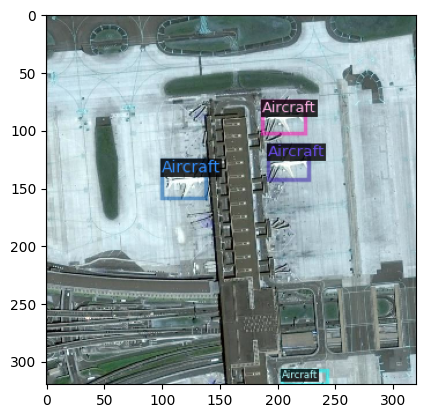

In [10]:
for d in random.sample(train_dataset_dicts, 1):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
  vis = visualizer.draw_dataset_dict(d)
  plt.imshow(vis.get_image()[:, :, ::-1])
  plt.show()

In [11]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/MyColabNotebook/models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2   # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 1e-3  # pick a good LR
cfg.SOLVER.MAX_ITER = 2500
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)


[12/29 01:00:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:06, 64.5MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


In [12]:
trainer.train()

[12/29 01:01:13 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/29 01:01:37 d2.utils.events]:  eta: 0:38:47  iter: 19  total_loss: 2.989  loss_cls: 1.47  loss_box_reg: 0.2622  loss_rpn_cls: 1.064  loss_rpn_loc: 0.1266    time: 0.9757  last_time: 1.0483  data_time: 0.0423  last_data_time: 0.0054   lr: 1.9981e-05  max_mem: 4394M
[12/29 01:02:00 d2.utils.events]:  eta: 0:39:02  iter: 39  total_loss: 1.92  loss_cls: 1.153  loss_box_reg: 0.2653  loss_rpn_cls: 0.1813  loss_rpn_loc: 0.1443    time: 0.9815  last_time: 1.0695  data_time: 0.0070  last_data_time: 0.0069   lr: 3.9961e-05  max_mem: 4394M
[12/29 01:02:20 d2.utils.events]:  eta: 0:39:32  iter: 59  total_loss: 1.556  loss_cls: 0.7471  loss_box_reg: 0.401  loss_rpn_cls: 0.2306  loss_rpn_loc: 0.1428    time: 0.9839  last_time: 0.9834  data_time: 0.0099  last_data_time: 0.0084   lr: 5.9941e-05  max_mem: 4394M
[12/29 01:02:39 d2.utils.events]:  eta: 0:39:11  iter: 79  total_loss: 1.066  loss_cls: 0.3783  loss_box_reg: 0.1948  loss_rpn_cls: 0.1959  loss_rpn_loc: 0.122    time: 0.9785  last_time: 0.

In [13]:
import yaml
config_yaml_path = "/content/drive/MyDrive/MyColabNotebook/models/Detectron2_Models/config.yaml"
with open(config_yaml_path, 'w') as file:
  yaml.dump(cfg, file)

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

[12/29 01:41:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/MyColabNotebook/models/Detectron2_Models/model_final.pth ...


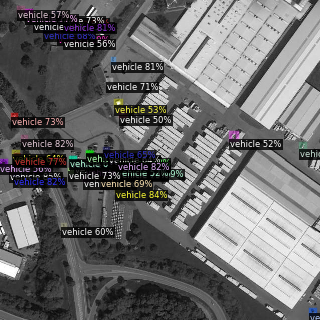

In [16]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`


[12/29 01:41:58 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[12/29 01:41:59 d2.data.datasets.coco]: Loaded 622 images in COCO format from /content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/val/_annotations.coco.json
[12/29 01:41:59 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  Aircraft  | 0            |    ship    | 1227         |  vehicle   | 38847        |
|            |              |            |              |            |              |
|   total    | 40074        |            |              |            |              |
[12/29 01:41:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/29 01:41:59 d2.data.common]:

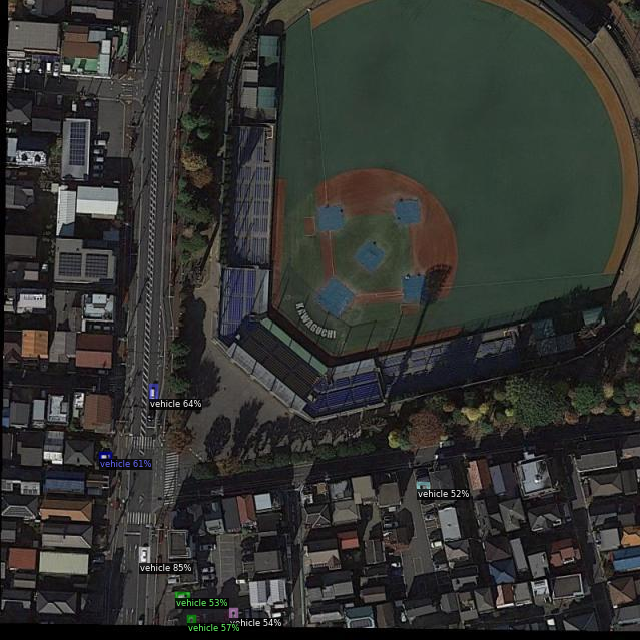

In [20]:
new_im = cv2.imread("/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/test/P0044__1-0__0___932_png_jpg.rf.ee04e7e3fb720f844df0beb64ce75bb0.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

In [29]:
# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/MyColabNotebook/data/car_plane_boat/test_results"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    try:
      outputs = predictor(new_im)
      if new_im is not None:
        v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

      # Create the output filename with _result extension
        result_filename = os.path.splitext(image_filename)[0] + "_result.jpg"
        output_path = os.path.join(output_directory, result_filename)

      # Save the segmented image
        cv2.imwrite(output_path, out.get_image()[:, :, ::-1])
    except AttributeError as e:
      if "NoneType" in str(e):
        # Handle the case where the image is None
        pass
     # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    if new_im is not None:
      v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
      out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.jpg"
    output_path = os.path.join(output_directory, result_filename)

